# Carlos Adrián García Estrada
# Matricula: A01707503
# Fecha de entrega: 19 de noviembre de 2023

# Solución: 
 
Para mi solución implente que durante el movimiento de los agentes se priorizar el seteo de aquellas celdas que serían stacks.
Se calculo el numero de stacks necesarios a través de la divisón de la cantidad de cajas entre la capacidad máxima de los stacks
resultando en 200 stacks.

Tambien se calcula en todo momento las celdas adyacentes al agente en las 4 direcciónes a través de la resta y suma correspondiente en
los ejes x y y.

Una vez hecho el calculo la primera acción del agente es encontrar celdas tanto vacías ( ni ocuapdas por otros agentes o por cajas)
como con cajas a su alrededor, si encuentra una caja del tamaño que sea la seteara como stack y esto se repetira por todos los agentes
hasta haber seteado los 40 stacks. Una vez hecho eso ahora el agente buscara si esta cargando o no una caja y si la celda con caja que 
eligio haya sido seteada como stack, si si ha sido seteada y esta cargando una caja dejará la caja. si no ha sido seteado como stack y 
no tiene una caja cargando entonces tomará una de las cajas.. SI ninguno de los casos se cumplen el agente se moverá a una celda vacía. 
De esto modo solo podemos tomar cajas de celdas que no han sido definidas como stack y solo ponerlas en aquellas que sí. Una vez que se 
hayan completado las 40 stacks de 5 cajas la simulación parará. Para el calculo de stacks completos cada vez que se coloca una nueva caja
se revisa si esta ha llegado a una cantidad de 5 stacks si llego entonces se le suma 1 a la cantidad de stacks completos y se le resta 1 a
stacks incompletos.

# Como eficientar el algoritmo 
Aunque los pasos son mas de 7000 la computacion de ellos es de hecho bastante rapida a comparación de la iteración de mi propuesta de solucion
para el cleaning Model. En este modelo los 7245 pasos tardan menos de 10 segundos en ser procesados. Para hacer aún más eficiente el algoritmo
se podría hacer array de las posiciónes de los stacks seteados y que puedan ser accedido por los agentes en cualquier momento, además de
crear un método que lleve al agente a la celda deseada step por step en vez de esperar a que por chance se encuentre.

In [53]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

from mesa.space import MultiGrid

#Importamos Random Activation ya que queremos que los agentes tomen decisiones 1 a la vez para evitar conflictos de choque
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

#Importamos random para obtener coordenadas al azar para setear nuestros dirty cells
import random

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [54]:
class OrderingAgent(Agent):
    def __init__(self, unique_id, model):
        random.seed(67890)  # Setting a specific seed for reproducibility
        super().__init__(unique_id, model)
        self.carrying_boxes = 0 

    def get_adjacent_cells(self):
        x, y = self.pos
        grid_width = self.model.grid.width
        grid_height = self.model.grid.height

        adjacent_cells = []

        # Left
        left_x = x - 1
        if left_x >= 0:
            adjacent_cells.append((left_x, y))

        # Right
        right_x = x + 1
        if right_x < grid_width:
            adjacent_cells.append((right_x, y))

        # Up
        up_y = y - 1
        if up_y >= 0:
            adjacent_cells.append((x, up_y))

        # Down
        down_y = y + 1
        if down_y < grid_height:
            adjacent_cells.append((x, down_y))

        return adjacent_cells
    
    def step(self):
        
        adjacent_cells = self.get_adjacent_cells()
        empty_cells = [cell for cell in adjacent_cells if (self.model.grid.is_cell_empty(cell) and 
                                                           self.model.get_type(cell[0], cell[1]) == 0)] 
        box_cells = [cell for cell in adjacent_cells if (0 < self.model.get_type(cell[0], cell[1]) < 5)] 

        if empty_cells:
            
            if box_cells:
                # Choose a random box cell
                chosen_box_cell = self.random.choice(box_cells)
                
                if self.model.get_total_stacks() < 40:

                    if self.model.get_stack(chosen_box_cell[0], chosen_box_cell[1]) == 0:
                        # If the chosen cell is not stacked and total stacks are less than 40, set stack
                            self.model.set_stack(chosen_box_cell[0], chosen_box_cell[1])
                    else:
                        empty_cell = self.random.choice(empty_cells)
                        self.model.grid.move_agent(self, empty_cell)

                else:
                    if self.model.get_stack(chosen_box_cell[0], chosen_box_cell[1]) == 0 and self.carrying_boxes == 0:
                        # If not carrying boxes, take a box and move to an empty cell
                        self.carrying_boxes += 1
                        self.model.take_box(chosen_box_cell[0], chosen_box_cell[1])
                        empty_cell = self.random.choice(empty_cells)
                        self.model.grid.move_agent(self, empty_cell)

                    if self.model.get_stack(chosen_box_cell[0], chosen_box_cell[1]) == 1 and self.carrying_boxes == 1: 
                        if self.carrying_boxes == 1:

                            # If carrying boxes, place a box and move to an empty cell
                            self.carrying_boxes -= 1
                            self.model.place_box(chosen_box_cell[0], chosen_box_cell[1])
                            empty_cell = self.random.choice(empty_cells)
                            self.model.grid.move_agent(self, empty_cell)
                    else:
                        empty_cell = self.random.choice(empty_cells)
                        self.model.grid.move_agent(self, empty_cell)
            else:
                # If no box cells, move to an empty cell
                empty_cell = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, empty_cell)

   

In [55]:
#En get_grid obtenemos los contenidos de nuestra celda y seteamos valores numéricos
#para después setear los colores en el grid

def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height), dtype=int)
    
    # Add agent positions to the grid
    for (content, (x, y)) in model.grid.coord_iter():
        if content:
            grid[x][y] = 1  # Agent is always represented by 1
        
        elif model.get_type(x, y) == 1: 
            grid[x][y] = 2  # Dirty cell (brown)

        elif model.get_type(x, y) == 2: 
            grid[x][y] = 3  # Dirty cell (brown)

        elif model.get_type(x, y) == 3: 
            grid[x][y] = 4  # Dirty cell (brown)

        elif model.get_type(x, y) == 4: 
            grid[x][y] = 5  # Dirty cell (brown)
        
        elif model.get_type(x, y) == 5: 
            grid[x][y] = 6  # Dirty cell (brown)

        else:
            grid[x][y] = 0  # Empty cell
    return grid

In [56]:
class OrderingModel(Model):
    def __init__(self, width, height, box_quantity, num_agents):
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        self.type = np.zeros((width, height))
        self.complete_stacks = 0
        self.incomplete_stacks = 0
        self.is_stack = np.zeros((width, height))
        self.running = True
        id = 1

        random.seed(67890)

        for x in range(width):
            for y in range(height):
                self.type[x][y] = 0
                self.is_stack[x][y] = 0

        for i in range(box_quantity):
            x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            while not (self.grid.is_cell_empty((x, y)) and self.get_type(x, y) == 0):
                x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            if box_quantity >= 3:
                choice = self.random.randint(1, 3)
            
            elif box_quantity == 2:
                choice = self.random.randint(1, 2)

            elif box_quantity == 1:
                choice = 1
            box_quantity = max(0, box_quantity - choice)
            self.type[x][y] = choice

            if box_quantity <= 0:
                break
        
        for i in range(num_agents):
            x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            while not (self.grid.is_cell_empty((x, y)) and self.get_type(x, y) == 0):
                x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            ordering_agent = OrderingAgent(id, self)
            self.grid.place_agent(ordering_agent, (x, y))
            self.schedule.add(ordering_agent)
            id = id + 1
        
    def take_box(self, x, y):
        self.type[x][y] -= 1

    def place_box(self, x, y):   
        self.type[x][y] += 1
        if self.type[x][y] == 5:
            self.complete_stacks += 1
            self.incomplete_stacks -= 1

    def get_type(self, x, y):
        return self.type[x][y]

    def set_stack(self, x, y):
        if self.is_stack[x][y] == 0:
            self.is_stack[x][y] = 1
            self.incomplete_stacks += 1

    def get_stack(self, x, y):
        return self.is_stack[x][y]

    def get_total_stacks(self):
        return self.incomplete_stacks + self.complete_stacks

    def step(self):

        self.datacollector.collect(self)
        self.schedule.step()

        if self.complete_stacks == 40:
            print("Simulación completa")
            self.running = False

              

In [57]:
WIDTH = 20
HEIGHT = 20
BOX_QUANTITY = 200  
NUM_AGENTS = 5

start_time = time.time()

model = OrderingModel(WIDTH, HEIGHT, BOX_QUANTITY, NUM_AGENTS)

step_counter = 0

while model.running:
    model.step()
    step_counter += 1
    
print('Numero de pasos:', step_counter)
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Simulación completa
Numero de pasos: 7245
Tiempo de ejecución: 0:00:10.002596


In [58]:
#Recolectamos los datos del grid 
all_grid = model.datacollector.get_model_vars_dataframe()

C:\Users\Charlie\AppData\Local\Temp\ipykernel_17864\697283093.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=6)
C:\Users\Charlie\AppData\Local\Temp\ipykernel_17864\697283093.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


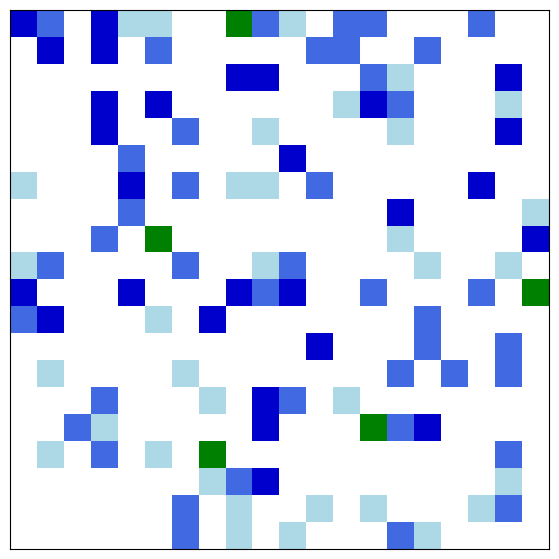

In [59]:
# Modify the animation code
fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])

# Define colors for agents and boxes
cmap = plt.cm.colors.ListedColormap(['white', 'green', 'lightblue', 'royalblue', 'mediumblue', 'darkblue', 'black'])

# Use colorbar to show the legend
bounds = [0, 1, 2, 3, 4, 5, 6]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# Initial rendering
patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=6)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    patch.set_clim(vmin=0, vmax=6)  #establecemos los limites del color

anim = animation.FuncAnimation(fig, animate, frames=step_counter)


In [60]:
anim

C:\Users\Charlie\AppData\Local\Temp\ipykernel_17864\697283093.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


KeyboardInterrupt: 